In [129]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset


from captum.attr import IntegratedGradients, NoiseTunnel, GradientShap, Occlusion, visualization as viz, LayerGradCam, GuidedBackprop

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from CustomCNN import CustomCNN

In [130]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [131]:
# Defined dataset
dataset_type = 'vary_disk'

data = torch.load(f'./data/classification_custom_dataset/{dataset_type}.pth')
images = data['images'].float() / 255.0 # Normalizing images
labels = data['labels']

# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Instantiate the model
model = CustomCNN(channels=32, kernel_size=3).cuda()

# Load the weights
model.load_state_dict(torch.load(f"./Models/custom_cnn_classification_{dataset_type}.pth"))
model.eval()  # Set the model to evaluation mode

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

In [132]:
# Pick two images for each class
selected_images = {i: [] for i in range(2)}
selected_labels = {i: [] for i in range(2)}

for image, label in dataset:
    if len(selected_images[label.item()]) < 10:
        selected_images[label.item()].append(image)
        selected_labels[label.item()].append(label)

    # Break if we have collected 2 images for each digit
    if all(len(images) == 10 for images in selected_images.values()):
        break

# Create a flat list of images to match the order of attributions
selected_images_list = [img for _, imgs in selected_images.items() for img in imgs]

# Verification
for label, images in selected_images.items():
    print(f"For class {label}, selected {len(images)} images.")

For class 0, selected 10 images.
For class 1, selected 10 images.


In [133]:
def imshow(img):
    # Convert from Tensor image
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img, cmap='gray')

# To store results for all images
results = []

# Iterate over labels and their corresponding images
for label, images in selected_images.items():
    for idx, image in enumerate(images):
        # Add batch dimension and run the model
        with torch.no_grad():
            image_cuda = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU
            output = model(image_cuda)
            predicted_label = torch.argmax(output).item()
            probabilities = F.softmax(output, dim=1)  # Apply softmax to get the probabilities
            prediction_score = probabilities[0][predicted_label].item()  # Confidence score for the predicted label
        
        # Store the results
        result = {
            "Image": image,  # Store the image tensor for later plotting
            "True Label": label,
            "Predicted Label": predicted_label,
            "Confidence Score": prediction_score,
            "Probability Distribution": probabilities[0].tolist()
        }
        results.append(result)

# Isolating predicted labels
predicted_labels = [res["Predicted Label"] for res in results]

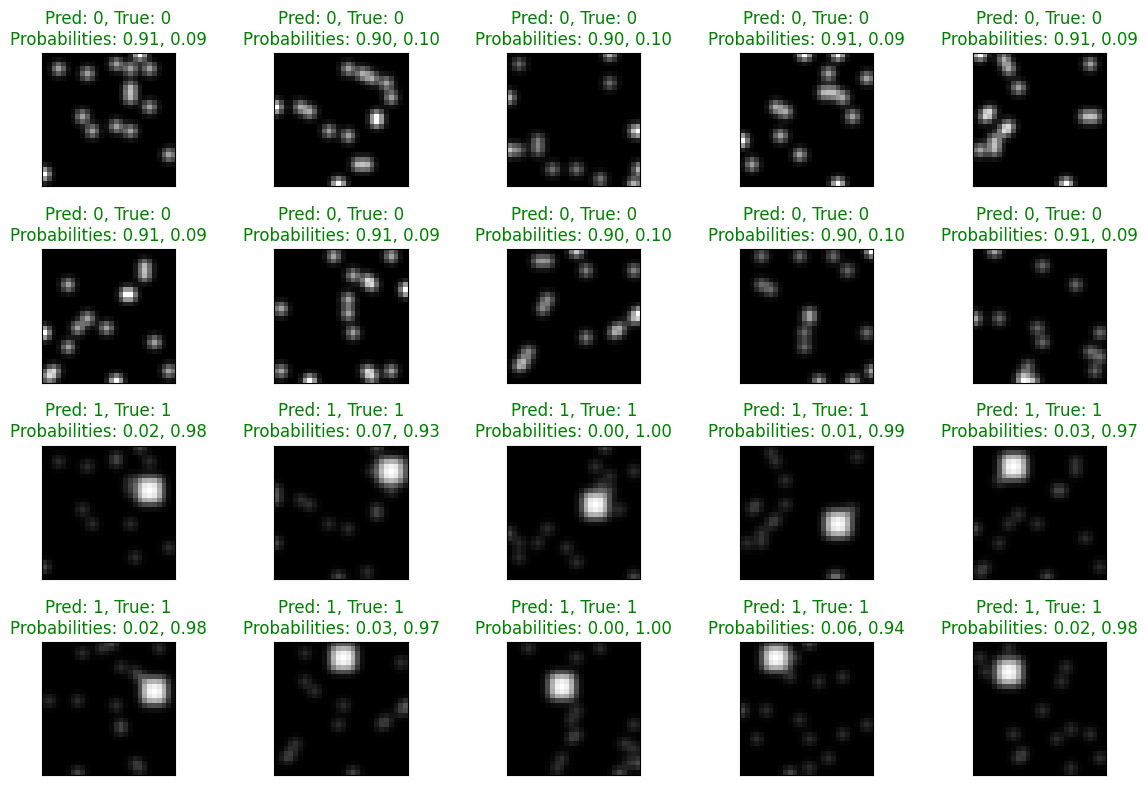

In [134]:
# Plotting the images with their predicted and true labels
i = 0
fig = plt.figure(figsize=(12, 8))
for res in results:
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])  # batch 32, 4 x 8
    _ = imshow(res["Image"])
    
    # Formatting the probabilities for display
    probabilities_str = ", ".join([f"{p:.2f}" for p in res["Probability Distribution"]])
    
    title_text = (f"Pred: {res['Predicted Label']}, True: {res['True Label']}\n"
                  f"Probabilities: {probabilities_str}")
    
    ax.set_title(title_text, 
                 color=("green" if res['Predicted Label'] == res['True Label'] else "red"))
    i += 1
_ = plt.tight_layout()  # Add padding between subplots
_ = plt.show()

In [135]:
integrated_gradients = IntegratedGradients(model)

# Store the attributions for each image
attributions_list = []

# Iterate over images and results
for (label, images), res in zip(selected_images.items(), results):
    for idx, image in enumerate(images):
        predicted_label = res["Predicted Label"]  # Retrieve the predicted label from results
        transformed_img = image.unsqueeze(0).cuda()  # Add batch dimension and send to device

        # Compute the attributions using Integrated Gradients
        attributions_ig = integrated_gradients.attribute(transformed_img, target=predicted_label, n_steps=20)
        attributions_list.append(attributions_ig)

In [136]:
# Lists to store reshaped attributions and images
attributions_reshaped_list = []
images_reshaped_list = []

# Compute all attributions and determine global min and max
global_min = float('inf')
global_max = float('-inf')

for attributions, image in zip(attributions_list, selected_images_list):
    attr_reshaped = attributions.squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    
    attributions_reshaped_list.append(attr_reshaped)
    images_reshaped_list.append(img_reshaped)
    
    global_min = min(global_min, attr_reshaped.min())
    global_max = max(global_max, attr_reshaped.max())

/tmp/ipykernel_15426/1546612410.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/1546612410.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/1546612410.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/15466124

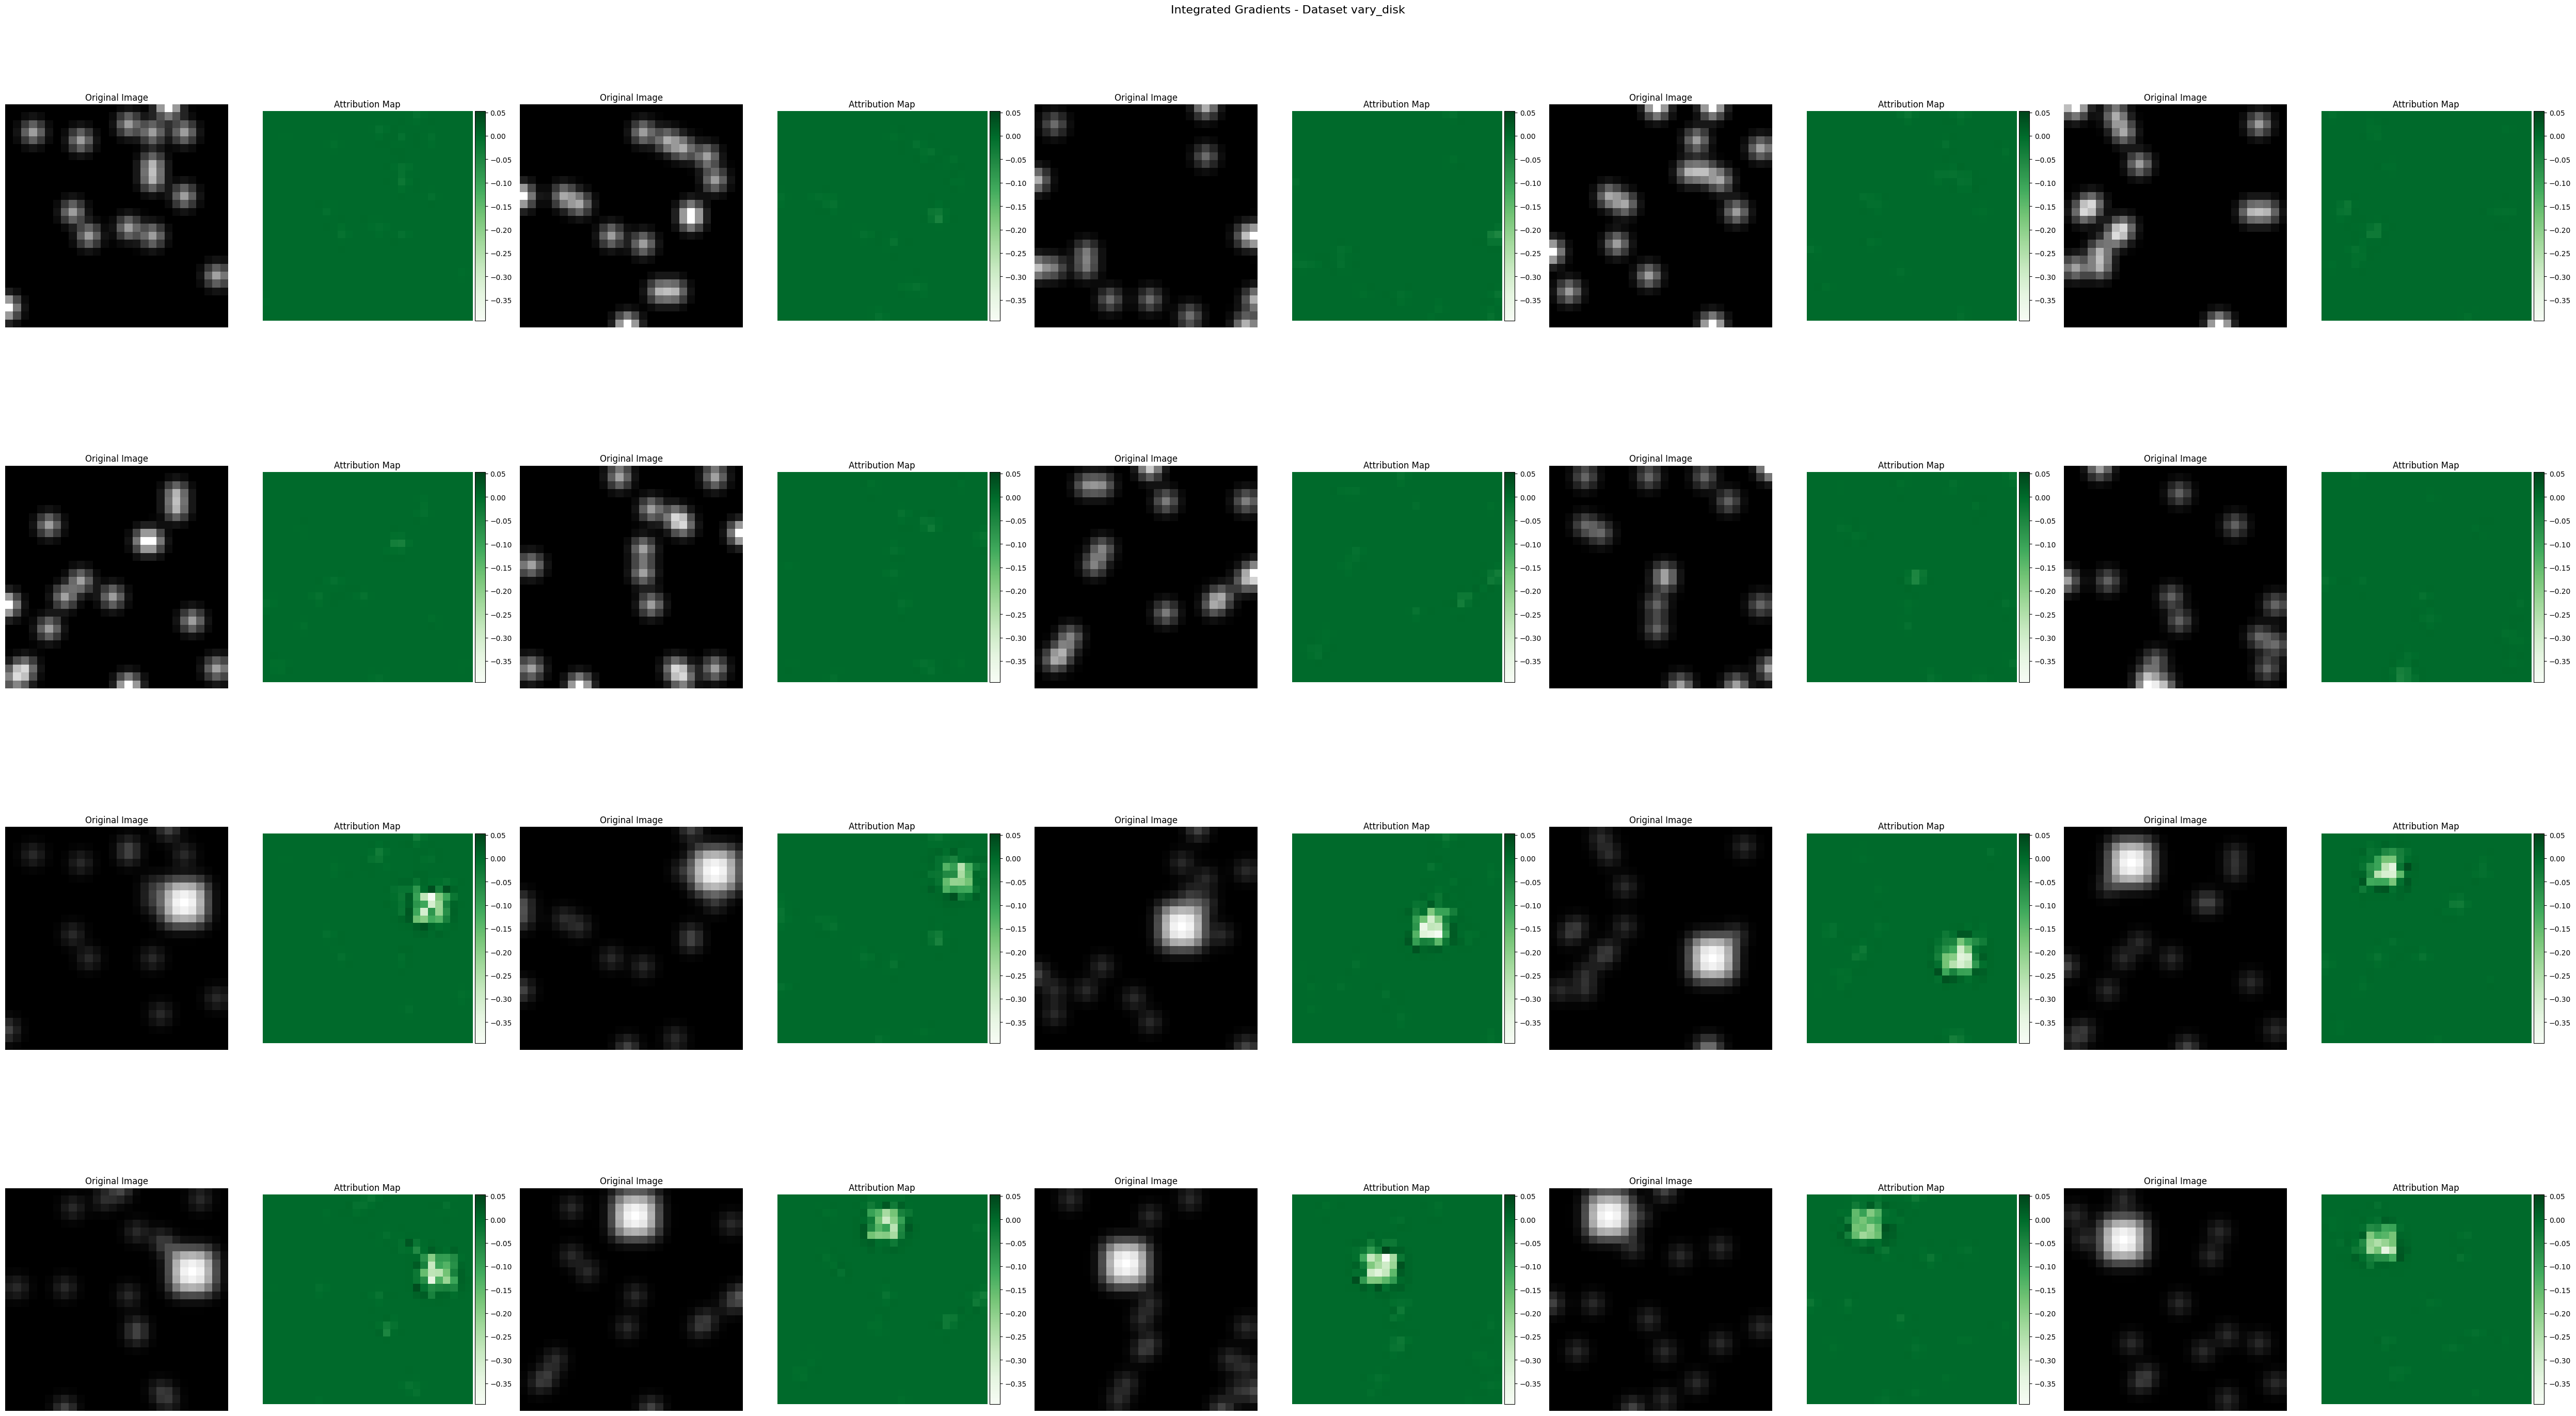

In [137]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Integrated Gradients - Dataset {dataset_type}', fontsize=16)

# Iterate over the reshaped attributions and images for plotting
for idx, (attr_reshaped, img_reshaped) in enumerate(zip(attributions_reshaped_list, images_reshaped_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side
    
    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution using the global min and max
    im = axes[row, col+1].imshow(attr_reshaped, cmap='Greens', vmin=global_min, vmax=global_max)
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/integrated_gradients_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

In [138]:
gradient_shap = GradientShap(model)
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Lists to store reshaped attributions and images
attributions_reshaped_list = []
images_reshaped_list = []

# Compute all attributions and determine global min and max
global_min = float('inf')
global_max = float('-inf')

for image, predicted_label in zip(selected_images_list, predicted_labels):
    
    # Prepare the image for model
    input_img = image.unsqueeze(0).cuda()  # Add batch dimension
    
    # Defining baseline distribution of images for GradientShap
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])
    
    # Generate attributions using GradientShap
    attributions_gs = gradient_shap.attribute(input_img,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=predicted_label)
    
    attr_reshaped = attributions_gs.squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    
    attributions_reshaped_list.append(attr_reshaped)
    images_reshaped_list.append(img_reshaped)
    
    global_min = min(global_min, attr_reshaped.min())
    global_max = max(global_max, attr_reshaped.max())

/tmp/ipykernel_15426/2250741054.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/2250741054.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/2250741054.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/2250741054.py:26: MatplotlibD

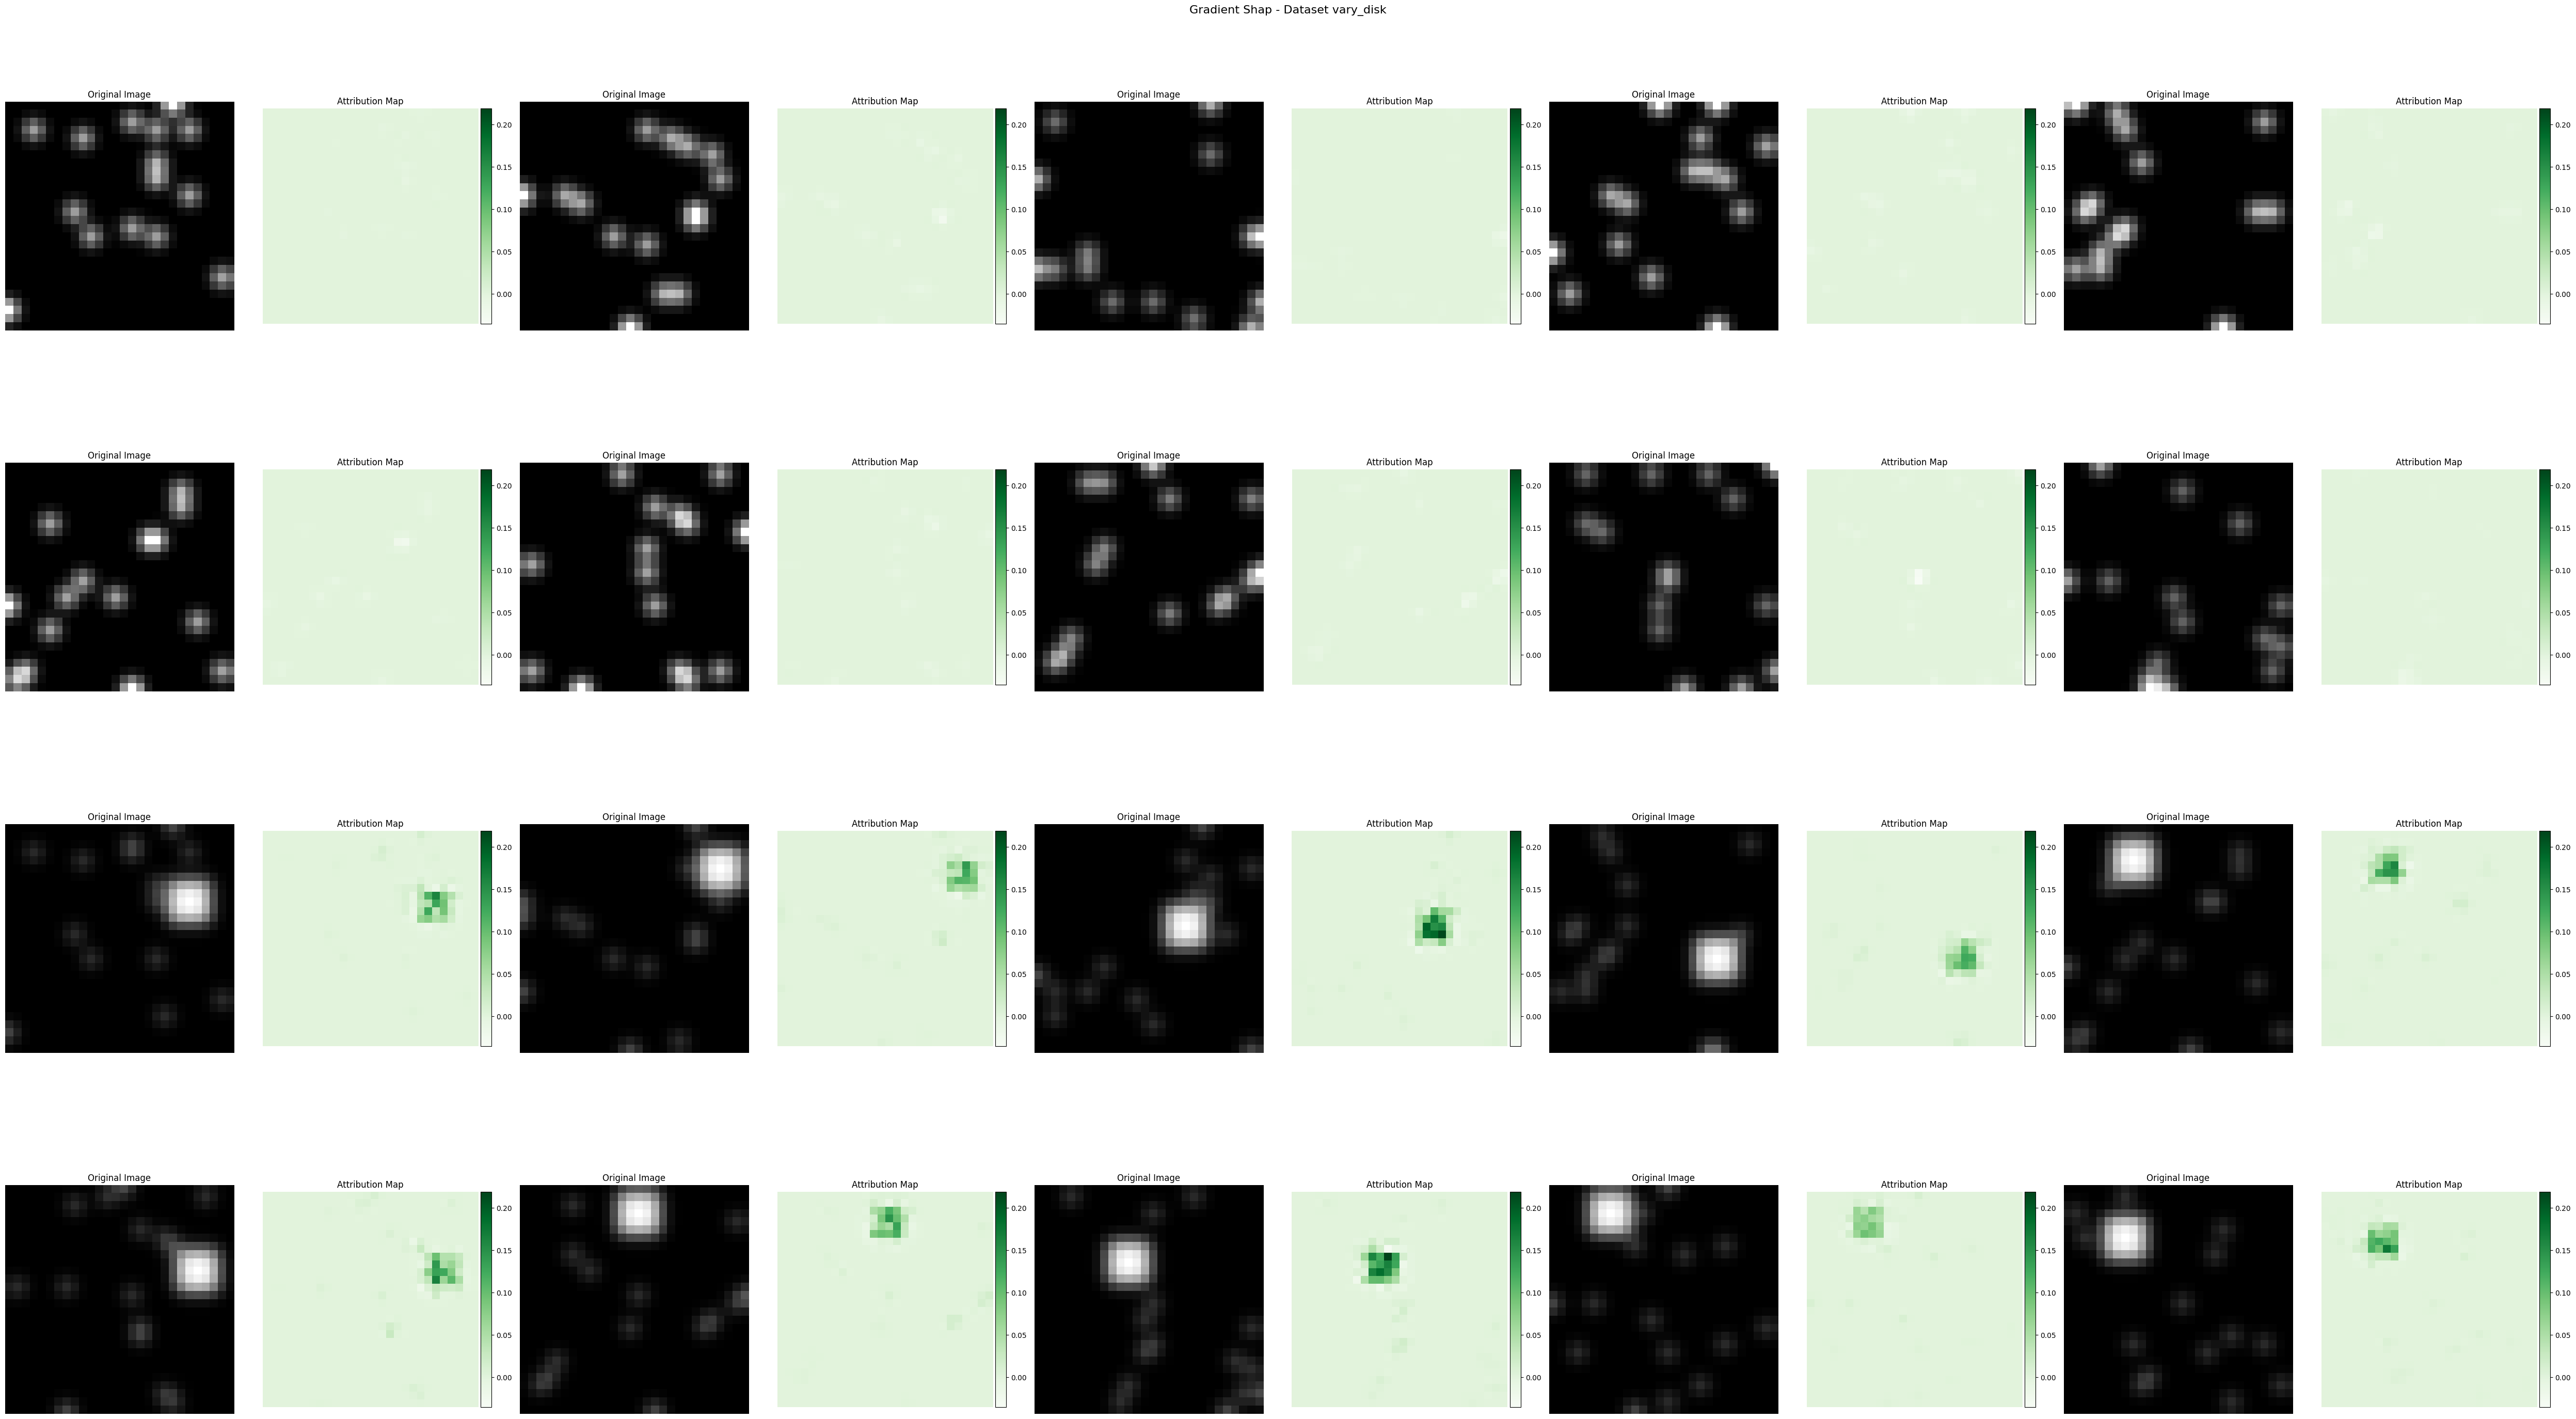

In [139]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Gradient Shap - Dataset {dataset_type}', fontsize=16)

# Iterate over the reshaped attributions and images for plotting
for idx, (attr_reshaped, img_reshaped) in enumerate(zip(attributions_reshaped_list, images_reshaped_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side
    
    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution using the global min and max
    im = axes[row, col+1].imshow(attr_reshaped, cmap='Greens', vmin=global_min, vmax=global_max)
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/gradient_shap_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

In [140]:
occlusion = Occlusion(model)

# Lists to store reshaped attributions and images
attributions_reshaped_list = []
images_reshaped_list = []

# Compute all attributions and determine global min and max
global_min = float('inf')
global_max = float('-inf')

# First loop for generating attributions
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using Occlusion
    input_img = image.unsqueeze(0).cuda()  # Add batch dimension
    attributions_occ = occlusion.attribute(input_img,
                                           strides=(1, image.shape[1] // 20, image.shape[1] // 20),
                                           target=predicted_label,
                                           sliding_window_shapes=(1, image.shape[1] // 10, image.shape[1] // 10),
                                           baselines=0)

    attr_reshaped = attributions_occ.squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)

    attributions_reshaped_list.append(attr_reshaped)
    images_reshaped_list.append(img_reshaped)
    
    global_min = min(global_min, attr_reshaped.min())
    global_max = max(global_max, attr_reshaped.max())

/tmp/ipykernel_15426/3632553998.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/3632553998.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/3632553998.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/3632553998.py:26: MatplotlibDeprecationWa

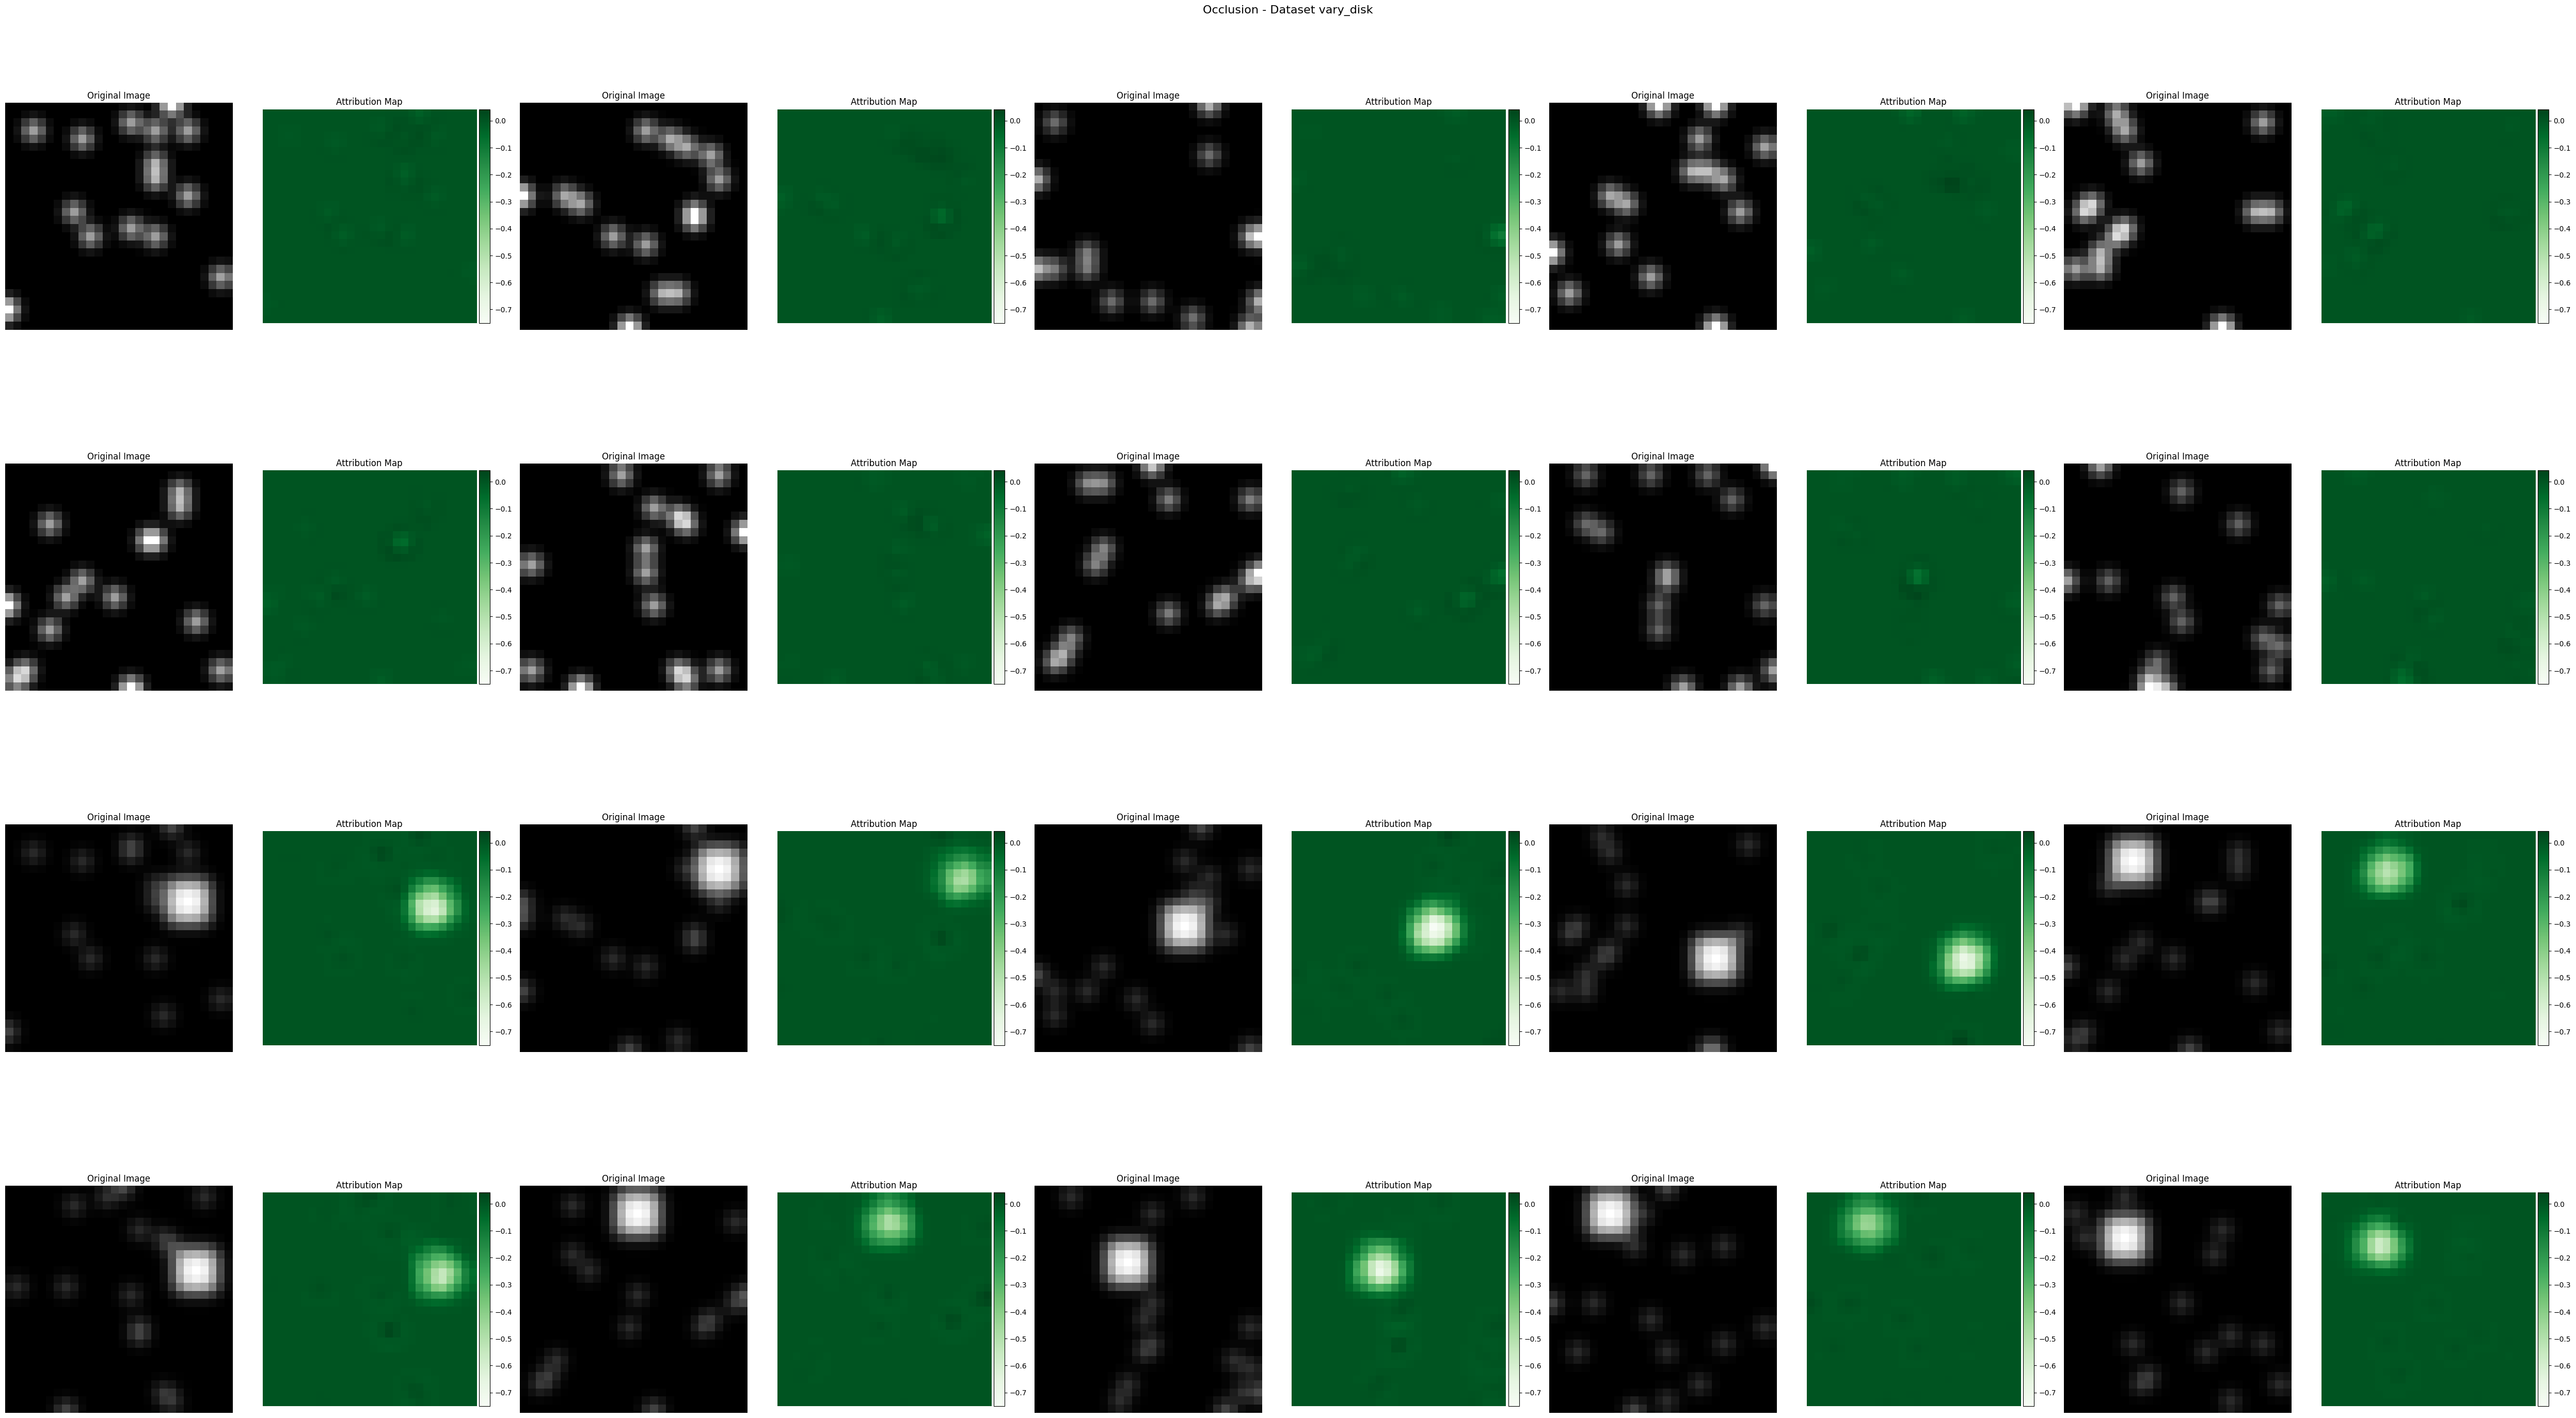

In [141]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Occlusion - Dataset {dataset_type}', fontsize=16)

# Second loop for plotting
for idx, (attr_reshaped, img_reshaped) in enumerate(zip(attributions_reshaped_list, images_reshaped_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution using the global min and max
    im = axes[row, col+1].imshow(attr_reshaped, cmap='Greens', vmin=global_min, vmax=global_max)
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/occlusion_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

/tmp/ipykernel_15426/1374016603.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/captum_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/1374016603.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/captum_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/1374016603.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/captum_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/13740

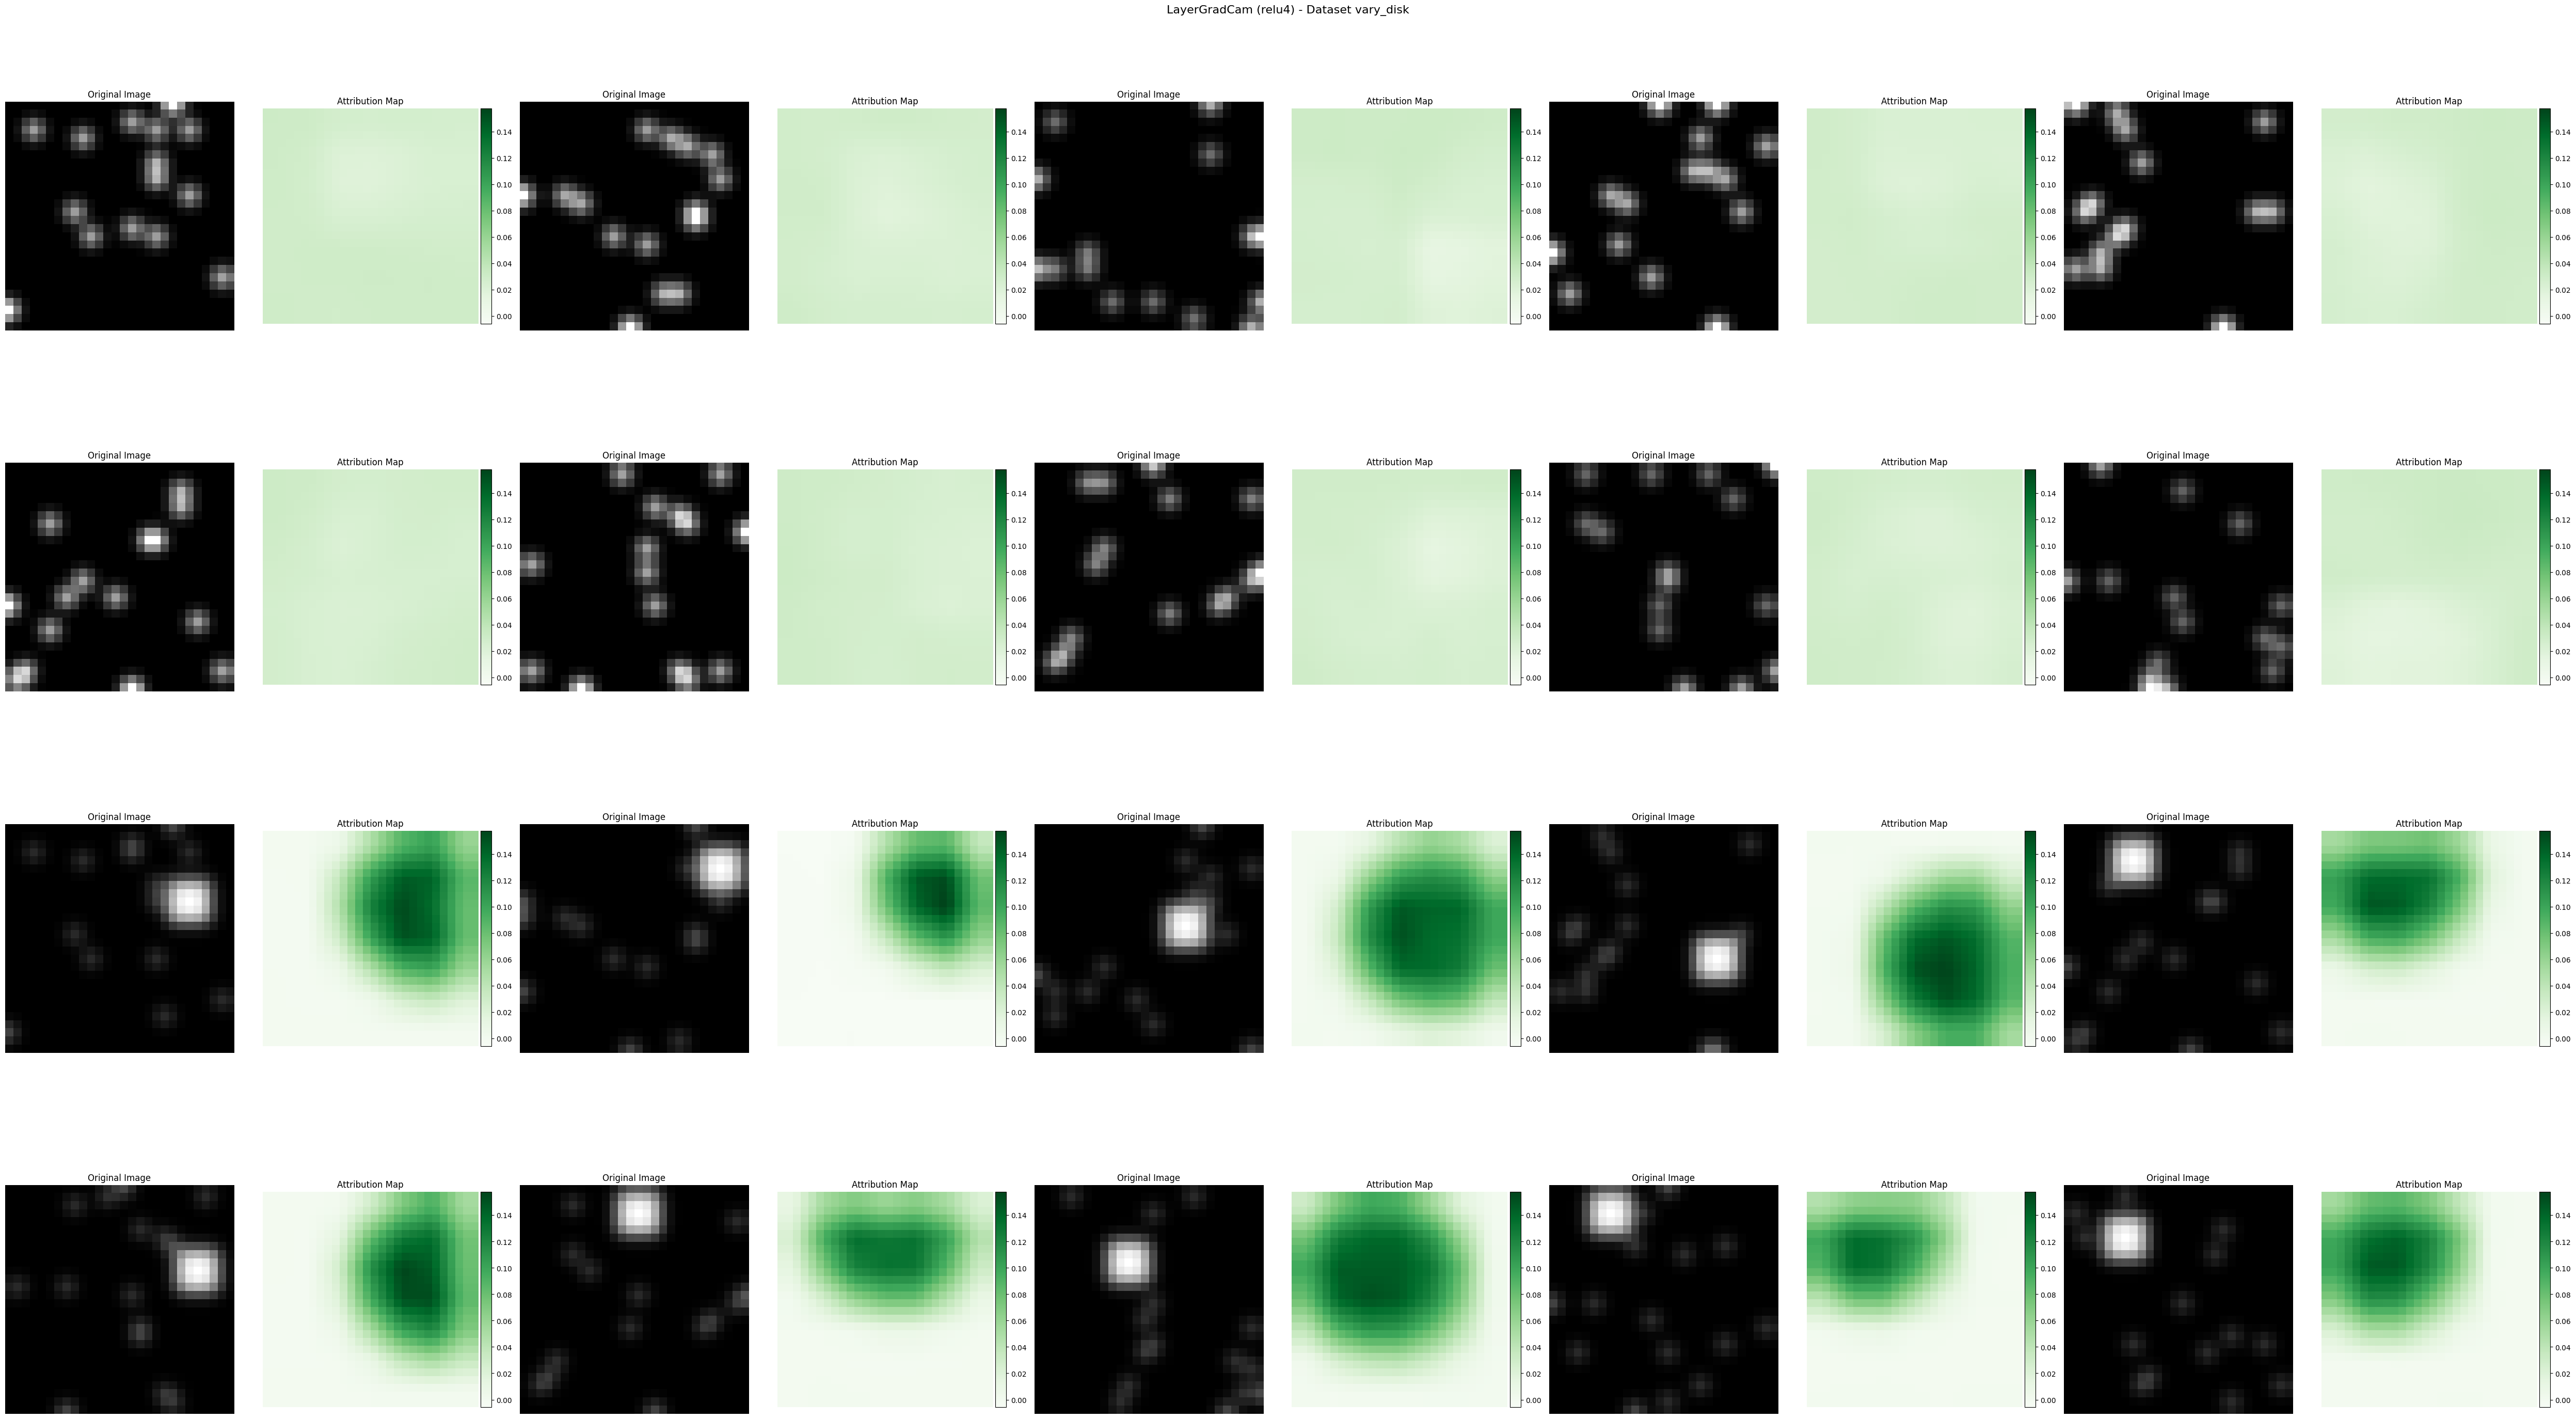

In [142]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'LayerGradCam (relu4) - Dataset {dataset_type}', fontsize=16)

layer_gc = LayerGradCam(model, model.relu4)

# Lists to store reshaped attributions and images
attributions_reshaped_list = []
images_reshaped_list = []

# Compute all attributions and determine global min and max
global_min = float('inf')
global_max = float('-inf')

# First loop for generating attributions
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using LayerGradCam
    input_img = image.unsqueeze(0).cuda()  # Add batch dimension
    attributions_lgc = layer_gc.attribute(input_img, target=predicted_label)
    
    # Resize the attribution tensor to match the input image size
    attributions_lgc = F.interpolate(attributions_lgc, 
                                     size=input_img.shape[-2:], 
                                     mode='bilinear')

    attr_reshaped = attributions_lgc.squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)

    attributions_reshaped_list.append(attr_reshaped)
    images_reshaped_list.append(img_reshaped)
    
    global_min = min(global_min, attr_reshaped.min())
    global_max = max(global_max, attr_reshaped.max())

# Second loop for plotting
for idx, (attr_reshaped, img_reshaped) in enumerate(zip(attributions_reshaped_list, images_reshaped_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution using the global min and max
    im = axes[row, col+1].imshow(attr_reshaped, cmap='Greens', vmin=global_min, vmax=global_max)
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/captum_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

In [143]:
def create_hook():
    storage = {'act':None}
    def hook(module, args, output):
        storage['act'] = output
    return hook, storage

def grad_cam(model, img, label):

    model.eval()
    model.cpu()

    hook, storage = create_hook()
    handler = model.relu4.register_forward_hook(hook)
    # Apply model to image
    y = model(img[None])[0]
    # Get layer activation
    A = storage['act']
    # Get class score
    y_c = y[label]
    # Calculate gradient of y_c with respect to A
    y_c.backward(inputs=A)
    # Get the gradient. A and A.grad have dimension (1,64,7,7)
    # We clone the tensor to make sure that it will not be erased
    dydA = A.grad[0].clone()
    # Detach A from the computational graph 
    A = A[0].detach()
    # Calculate the average over spatial dimensions. alpha has shape (64,1,1)
    alpha = dydA.mean(dim=(1, 2), keepdim=True)
    # Sum the activations weighted by alpha
    L = F.relu((alpha*A).sum(dim=0))
    # Interpolate the result to the same shape as the image
    atribution = F.interpolate(L.reshape(1,1,*L.shape), size=img.shape[-2:], mode='bilinear')
    atribution = atribution.squeeze()
    # Get probabilities. 
    probs = F.softmax(y.detach(), dim=0)

    # Remove hook
    handler.remove()

    return atribution, probs, A, dydA

In [144]:
# Lists to store reshaped attributions and images
attributions_reshaped_list = []
images_reshaped_list = []

# Compute all attributions and determine global min and max
global_min = float('inf')
global_max = float('-inf')

# First loop for generating attributions
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using LayerGradCam
    input_img = image
    attributions_lgc, probs, A, dydA = grad_cam(model, input_img, predicted_label)

    attr_reshaped = attributions_lgc.cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)

    attributions_reshaped_list.append(attr_reshaped)
    images_reshaped_list.append(img_reshaped)
    
    global_min = min(global_min, attr_reshaped.min())
    global_max = max(global_max, attr_reshaped.max())

/tmp/ipykernel_15426/336799355.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/cesar_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/336799355.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/cesar_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/336799355.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/cesar_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/336799355.p

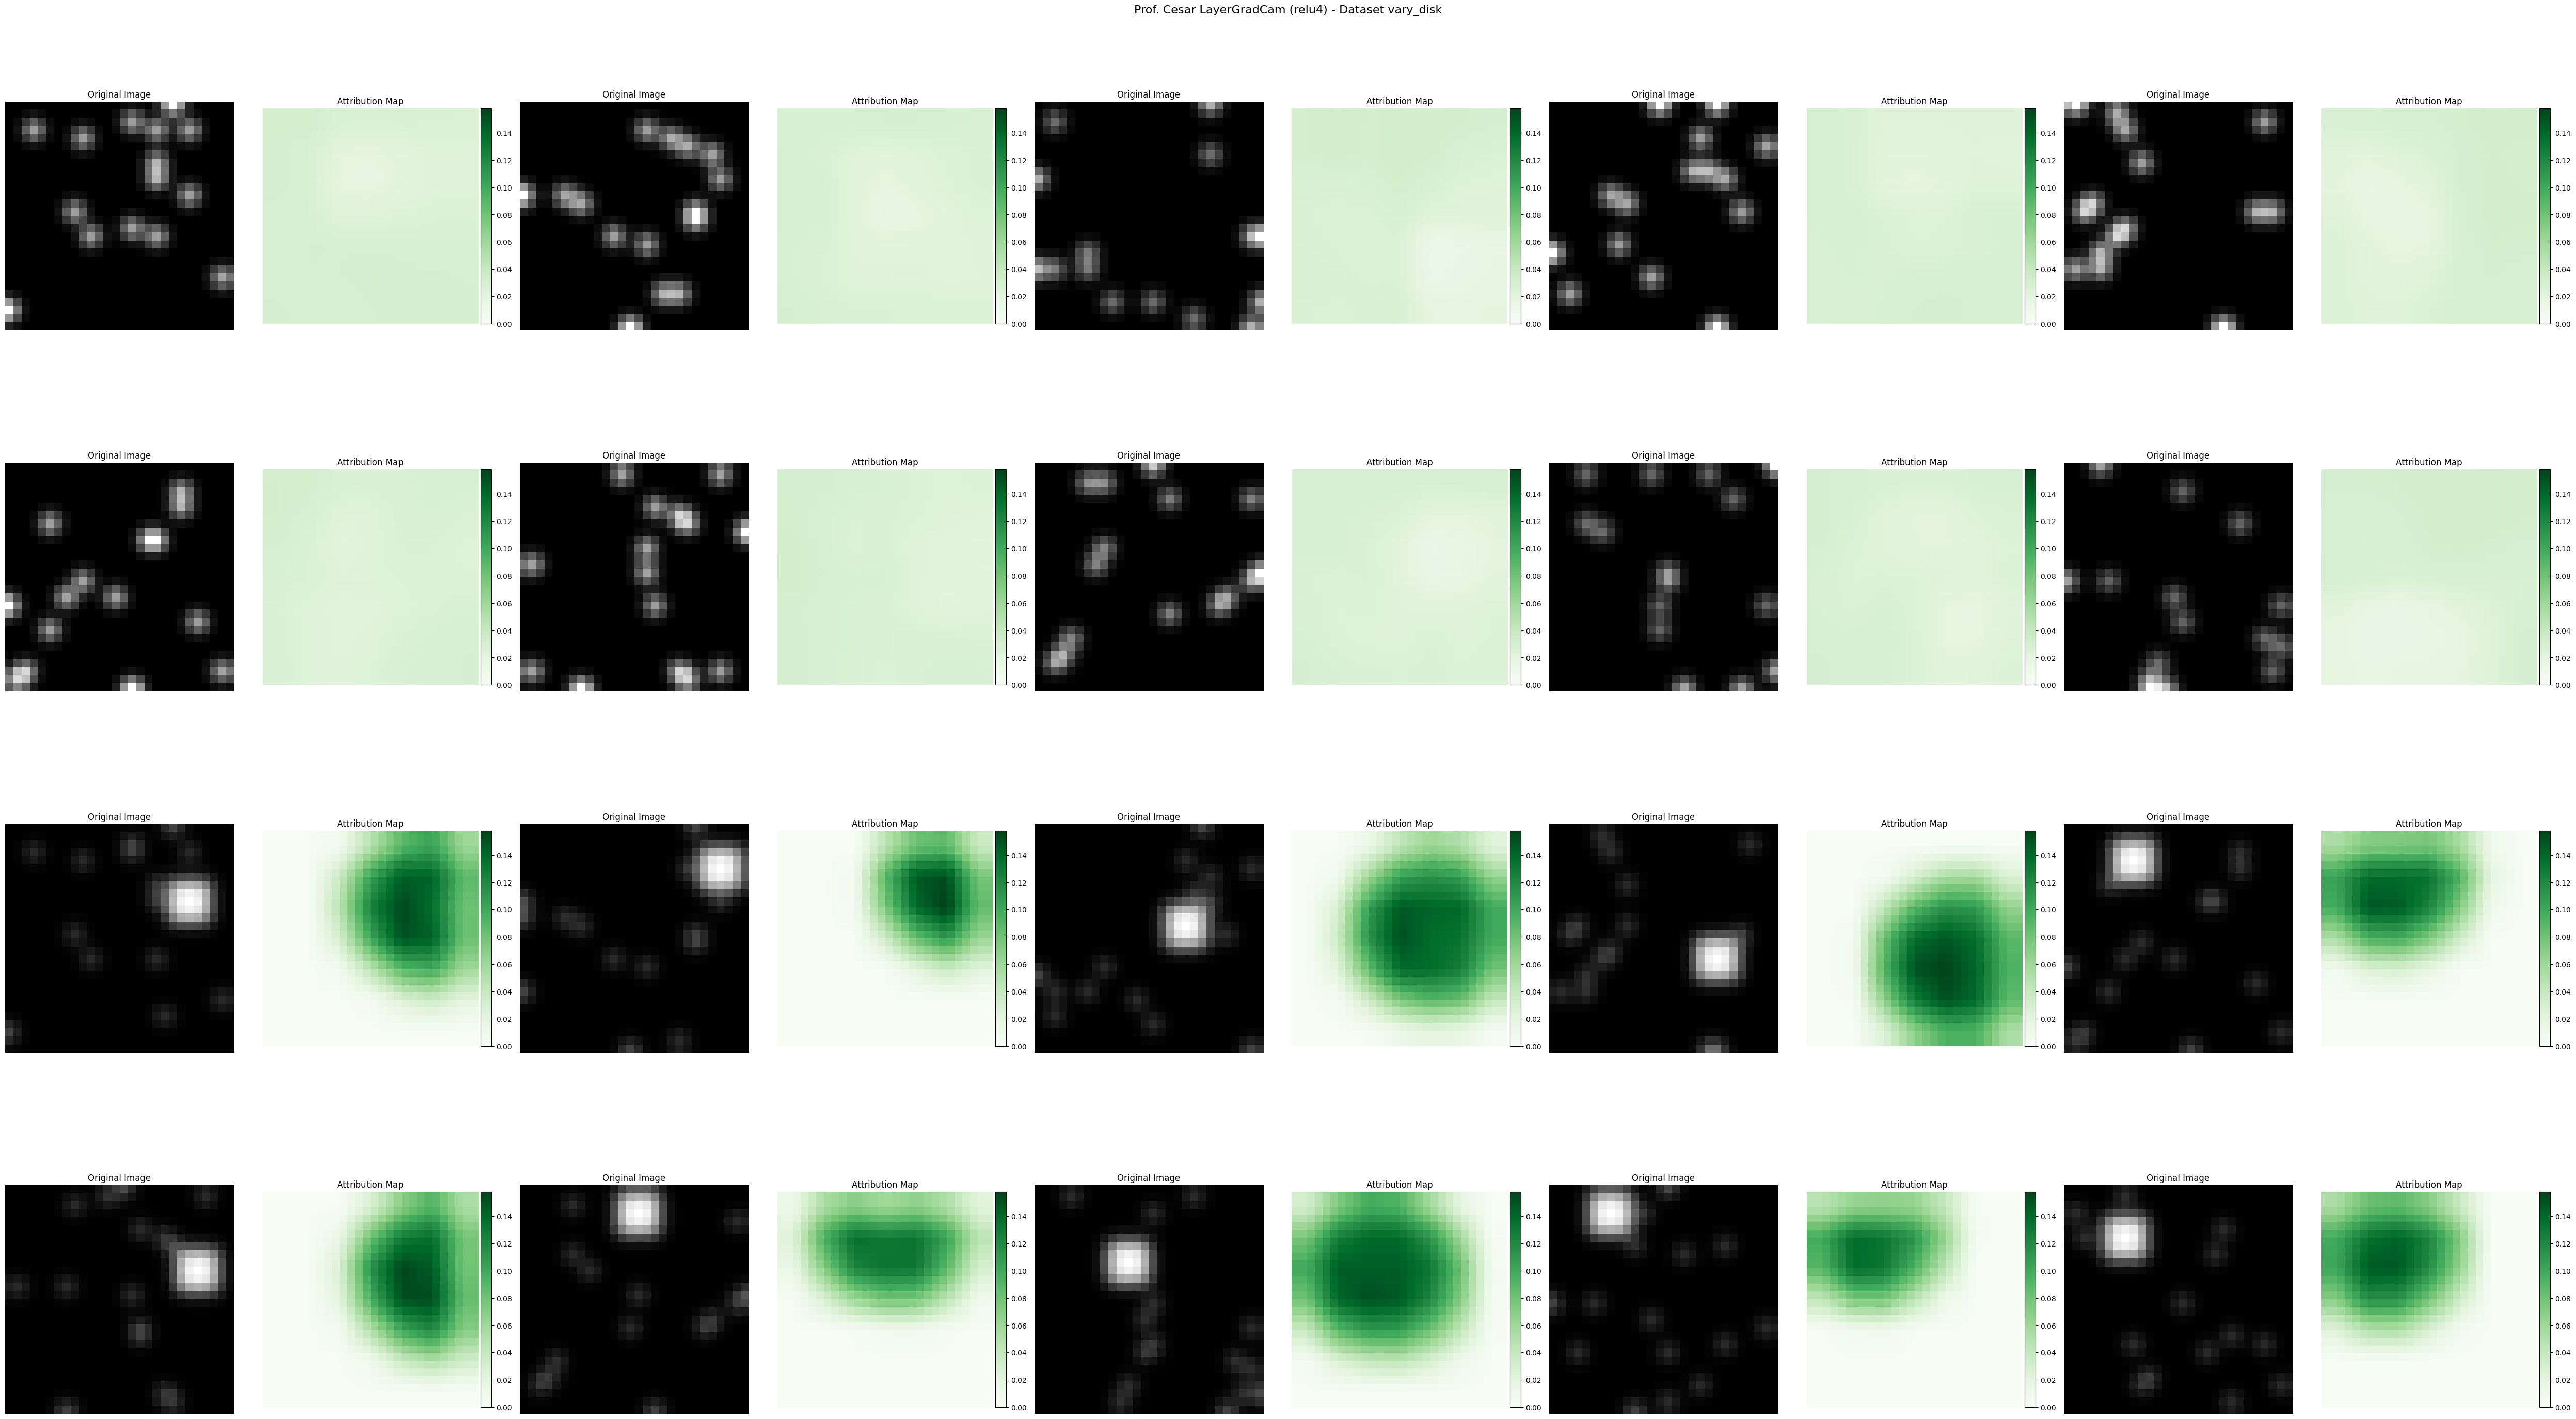

In [145]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Prof. Cesar LayerGradCam (relu4) - Dataset {dataset_type}', fontsize=16)

# Second loop for plotting
for idx, (attr_reshaped, img_reshaped) in enumerate(zip(attributions_reshaped_list, images_reshaped_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution using the global min and max
    im = axes[row, col+1].imshow(attr_reshaped, cmap='Greens', vmin=global_min, vmax=global_max)
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/cesar_grad_cam_relu4_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

In [146]:
guided_bp = GuidedBackprop(model)

# Lists to store reshaped attributions and images
attributions_reshaped_list = []
images_reshaped_list = []

# Compute all attributions and determine global min and max
global_min = float('inf')
global_max = float('-inf')

# First loop for generating attributions
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using GuidedBackprop
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_gb = guided_bp.attribute(input_img, target=predicted_label)

    attr_reshaped = attributions_gb.squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(image.shape[1], image.shape[1], 1)

    attributions_reshaped_list.append(attr_reshaped)
    images_reshaped_list.append(img_reshaped)
    
    global_min = min(global_min, attr_reshaped.min())
    global_max = max(global_max, attr_reshaped.max())

/tmp/ipykernel_15426/3092237540.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/guided_backprop_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/3092237540.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/guided_backprop_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/3092237540.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/guided_backprop_{dataset_type}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_15426/3092237540.py:26: Matpl

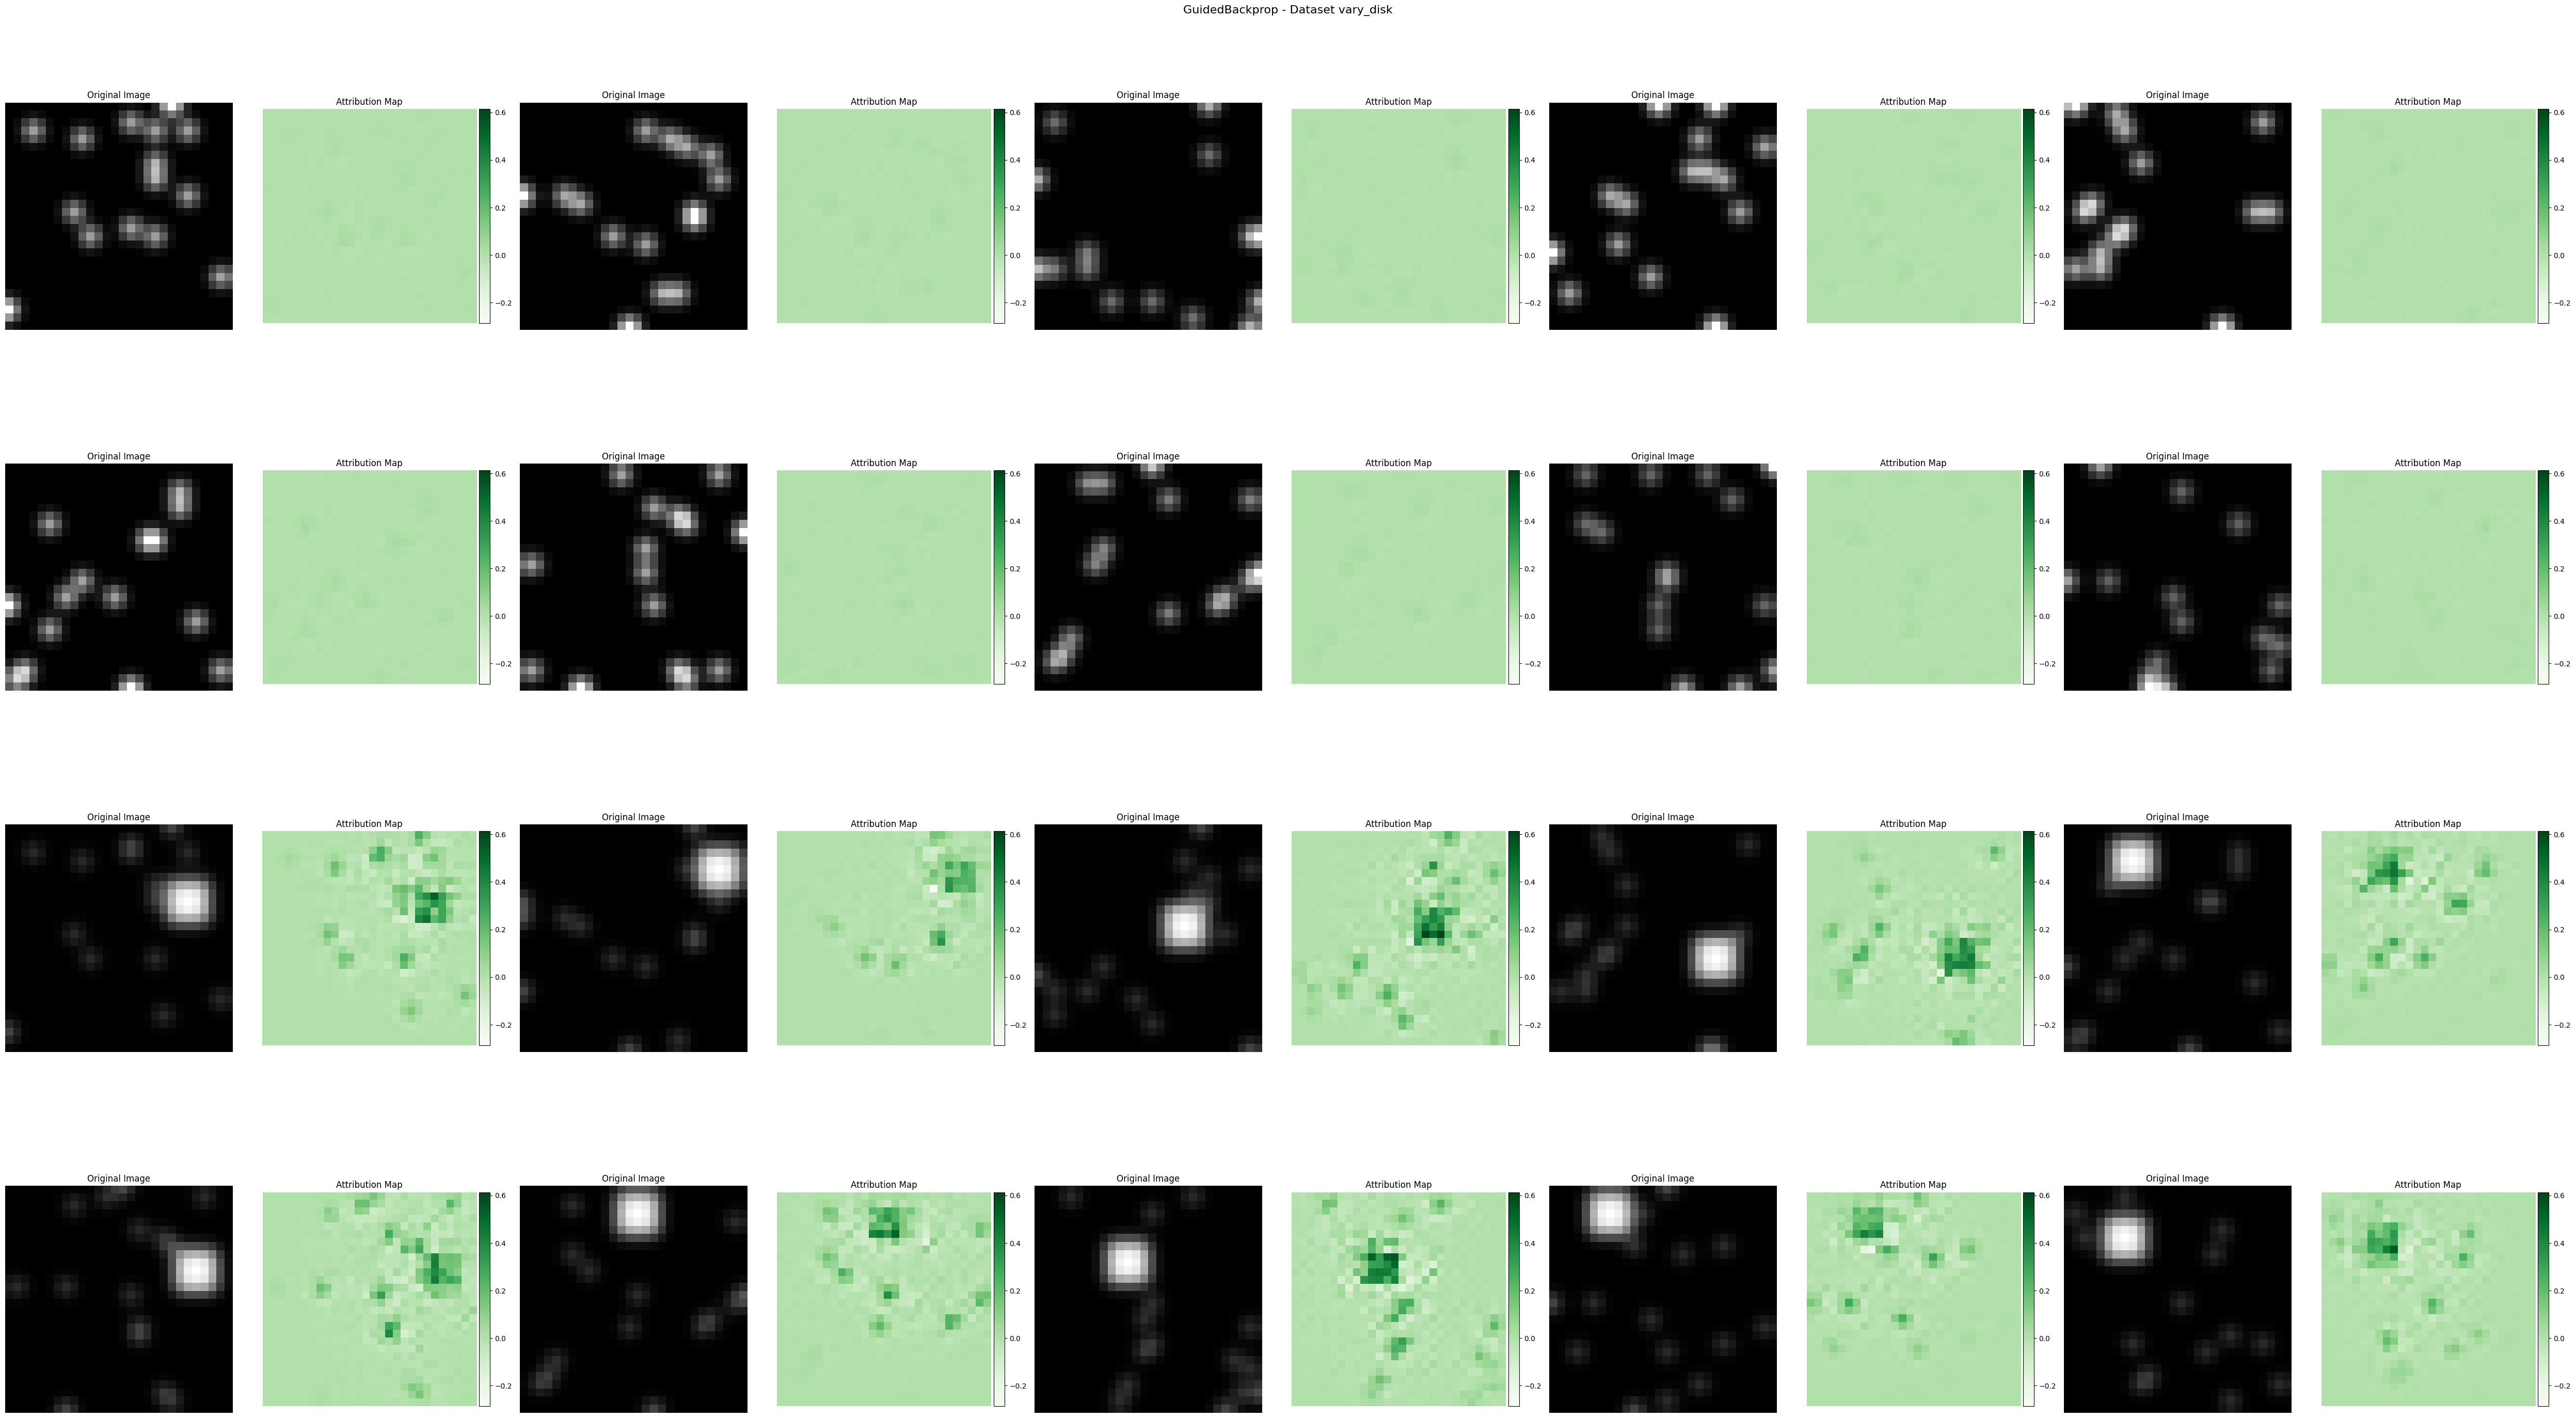

In [147]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'GuidedBackprop - Dataset {dataset_type}', fontsize=16)

# Second loop for plotting
for idx, (attr_reshaped, img_reshaped) in enumerate(zip(attributions_reshaped_list, images_reshaped_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution using the global min and max
    im = axes[row, col+1].imshow(attr_reshaped, cmap='Greens', vmin=global_min, vmax=global_max)
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/guided_backprop_{dataset_type}.png', bbox_inches='tight', dpi=300)
_ = plt.show()